# 1. Data Loading and Preprocessing

1.1 Data Loading

In [13]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

1.2 Data  Preprocessing

In [14]:
for image, label in train_dataset.take(1):
  print(image.shape, label)

for image, label in test_dataset.take(1):
  print(image.shape, label)


for image, label in validation_dataset.take(1):
  print(image.shape, label)

(500, 667, 3) tf.Tensor(72, shape=(), dtype=int64)
(542, 500, 3) tf.Tensor(40, shape=(), dtype=int64)
(500, 571, 3) tf.Tensor(88, shape=(), dtype=int64)


In [15]:
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224

def resize_image(image, label, height, width):
    image = tf.image.resize(image, (height, width))
    return image, label

train_dataset = train_dataset.map(lambda x, y: resize_image(x, y, IMG_HEIGHT, IMG_WIDTH))
validation_dataset = validation_dataset.map(lambda x, y: resize_image(x, y, IMG_HEIGHT, IMG_WIDTH))
test_dataset = test_dataset.map(lambda x, y: resize_image(x, y, IMG_HEIGHT, IMG_WIDTH))

(224, 224, 3) tf.Tensor(72, shape=(), dtype=int64)


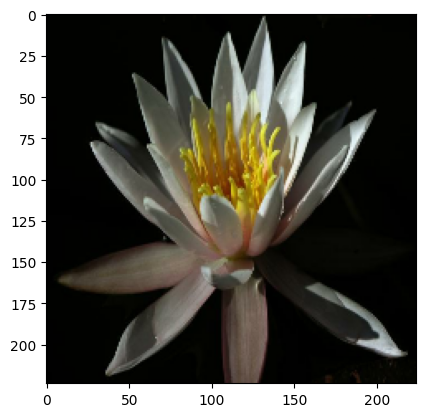

(224, 224, 3) tf.Tensor(40, shape=(), dtype=int64)


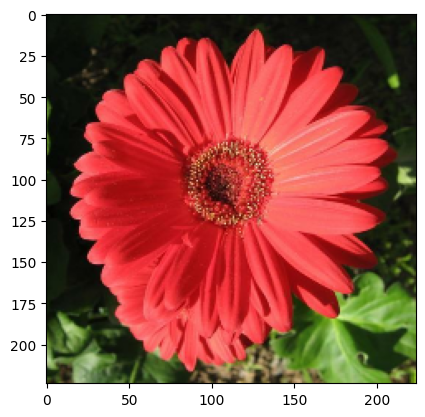

(224, 224, 3) tf.Tensor(88, shape=(), dtype=int64)


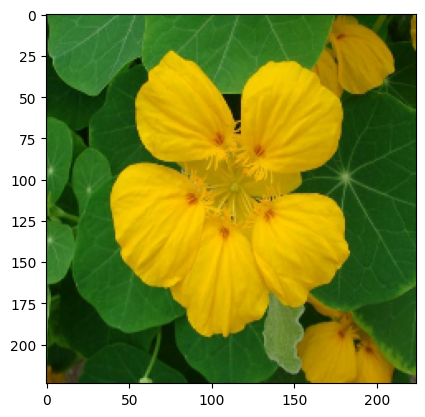

In [16]:
import matplotlib.pyplot as plt
for image, label in train_dataset.take(1):
  print(image.shape, label)
  plt.imshow(image/ 255.0)
  plt.show()

for image, label in test_dataset.take(1):
  print(image.shape, label)
  plt.imshow(image/ 255.0)
  plt.show()


for image, label in validation_dataset.take(1):
  print(image.shape, label)
  plt.imshow(image/ 255.0)
  plt.show()

In [17]:
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

X_train_resnet50 = train_dataset.map(lambda x, y: (preprocess_resnet50(x), y)).batch(32)
X_train_vgg16 = train_dataset.map(lambda x, y: (preprocess_vgg16(x), y)).batch(32)
X_train_mobilenetv2 = train_dataset.map(lambda x, y: (preprocess_mobilenetv2(tf.cast(x, dtype=tf.float32)), y)).batch(32)

X_validation_resnet50 = validation_dataset.map(lambda x, y: (preprocess_resnet50(x), y)).batch(32)
X_validation_vgg16 = validation_dataset.map(lambda x, y: (preprocess_vgg16(x), y)).batch(32)
X_validation_mobilenetv2 = validation_dataset.map(lambda x, y: (preprocess_mobilenetv2(tf.cast(x, dtype=tf.float32)), y)).batch(32)

X_test_resnet50 = test_dataset.map(lambda x, y: (preprocess_resnet50(x), y)).batch(32)
X_test_vgg16 = test_dataset.map(lambda x, y: (preprocess_vgg16(x), y)).batch(32)
X_test_mobilenetv2 = test_dataset.map(lambda x, y: (preprocess_mobilenetv2(tf.cast(x, dtype=tf.float32)), y)).batch(32)

y_train = train_dataset.map(lambda x, y: y).batch(32)
y_validation = validation_dataset.map(lambda x, y: y).batch(32)
y_test = test_dataset.map(lambda x, y: y).batch(32)

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
for images, labels in X_train_resnet50.take(1):
    print(images.shape)
    print(labels.shape)
    break


(32, 224, 224, 3)
(32,)


In [22]:
print(model_resnet50.input_shape)


(None, 224, 224, 3)


In [23]:
epochs = 30

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)



# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True


# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True




# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(
    X_train_resnet50,
    epochs=epochs,
    validation_data=X_validation_resnet50,
    callbacks=[early_stopping]  # <-- use callbacks keyword and pass list
)

history_vgg16 = model_vgg16.fit(
    X_train_vgg16,
    epochs=epochs,
    validation_data=X_validation_vgg16,
    callbacks=[early_stopping]
)

history_mobilenetv2 = model_mobilenetv2.fit(
    X_train_mobilenetv2,
    epochs=epochs,
    validation_data=X_validation_mobilenetv2,
    callbacks=[early_stopping]
)



178
22
157
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 644ms/step - accuracy: 0.2118 - loss: 4.1334 - val_accuracy: 0.0755 - val_loss: 44.1956
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.8305 - loss: 0.6841 - val_accuracy: 0.1765 - val_loss: 22.8545
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.9491 - loss: 0.2290 - val_accuracy: 0.2716 - val_loss: 12.8602
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9653 - loss: 0.1495 - val_accuracy: 0.2990 - val_loss: 9.8528
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9839 - loss: 0.0823 - val_accuracy: 0.4461 - val_loss: 5.6953
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.9896 - loss: 0.0512 - val_accuracy: 0.3794 - val_loss: 7.8033
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.9884 - loss: 0.0423 - val_accuracy: 0.3676 - val_loss: 8.7999
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.9953 - loss: 0.0188 - v

In [25]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')


193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.8439 - loss: 0.6240
193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.7166 - loss: 1.5498
193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.0972 - loss: 9.2959
ResNet50 Accuracy: 0.85
VGG16 Accuracy: 0.71
MobileNetV2 Accuracy: 0.10


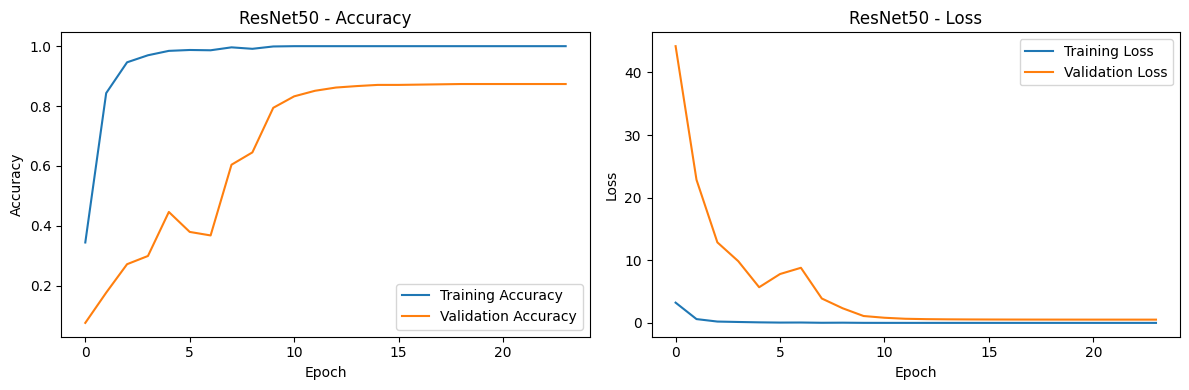

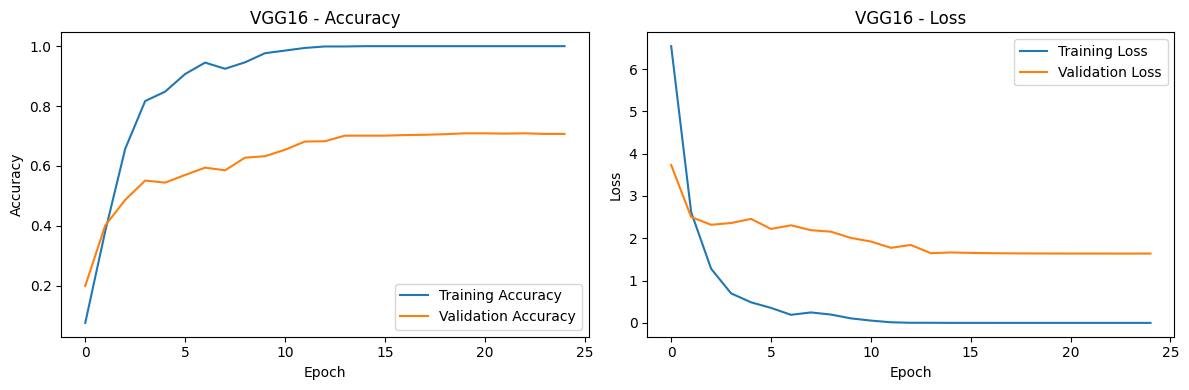

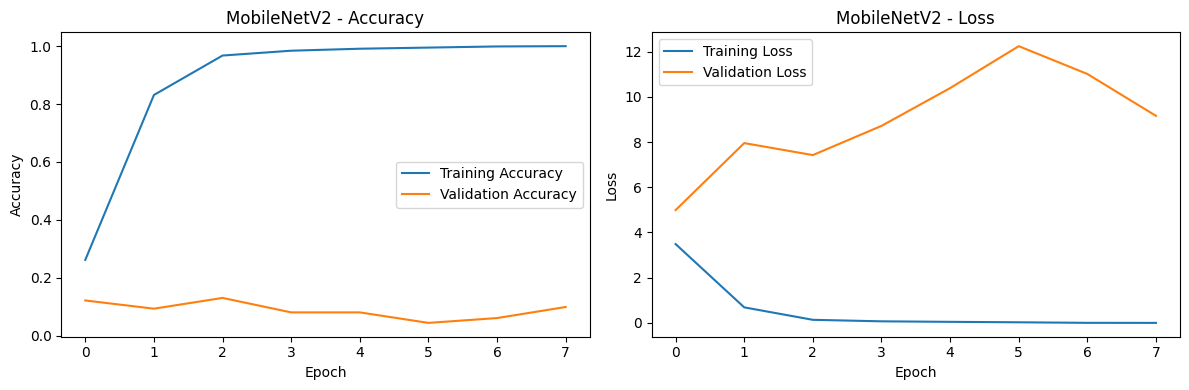

In [26]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')